In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os
import optuna
from utils import read_des
import matplotlib.pyplot as plt


In [3]:
des_path = 'HTE_descriptors/'
UniMol_19 = read_des(os.path.join(des_path, 'unimol/19_data'))

Catalyst_smirepr.csv的维度: (1075, 512)
Imine_smirepr.csv的维度: (1075, 512)
Thiol_smirepr.csv的维度: (1075, 512)
合并后的维度: (1075, 1536)


In [ ]:
# read out-of-sample split idx
classified_df = pd.read_csv('data/19_science/classified_idx.csv')
Train_idx = classified_df.index[classified_df['Subset'] == 'Train'].tolist()
Test_idx = classified_df.index[classified_df['Subset'] == 'Test_cat_sub'].tolist()  # Test_sub/Test_cat_sub

print(len(Train_idx),len(Test_idx))

# 特征和标签
X = UniMol_19
y = classified_df['Output']

X_train = X.iloc[Train_idx]
y_train = y.iloc[Train_idx]
X_test = X.iloc[Test_idx]
y_test = y.iloc[Test_idx]


384 171


[I 2025-08-05 18:21:59,978] A new study created in memory with name: no-name-2fdbe2af-7093-4618-95d2-de795e6a543d
[I 2025-08-05 18:22:00,000] Trial 0 finished with value: 0.6650550646458029 and parameters: {'alpha': 0.26448638291034243}. Best is trial 0 with value: 0.6650550646458029.


384 171


[I 2025-08-05 18:22:00,198] Trial 1 finished with value: 0.3752896020698721 and parameters: {'alpha': 0.0009001149257239577}. Best is trial 1 with value: 0.3752896020698721.
[I 2025-08-05 18:22:00,222] Trial 2 finished with value: 0.6275805187346003 and parameters: {'alpha': 0.09274019520543277}. Best is trial 1 with value: 0.3752896020698721.
[I 2025-08-05 18:22:00,249] Trial 3 finished with value: 0.6650550646458029 and parameters: {'alpha': 0.9234817291285852}. Best is trial 1 with value: 0.3752896020698721.
[I 2025-08-05 18:22:00,277] Trial 4 finished with value: 0.6650550646458029 and parameters: {'alpha': 0.9596074163079698}. Best is trial 1 with value: 0.3752896020698721.
[I 2025-08-05 18:22:00,420] Trial 5 finished with value: 0.37515842495841195 and parameters: {'alpha': 0.001081885995761968}. Best is trial 5 with value: 0.37515842495841195.
[I 2025-08-05 18:22:00,446] Trial 6 finished with value: 0.6234943278808198 and parameters: {'alpha': 0.08511508461493245}. Best is trial


Best Lasso params: {'alpha': 0.00010007187702478538}
Best Lasso MAE on test set: 0.3554


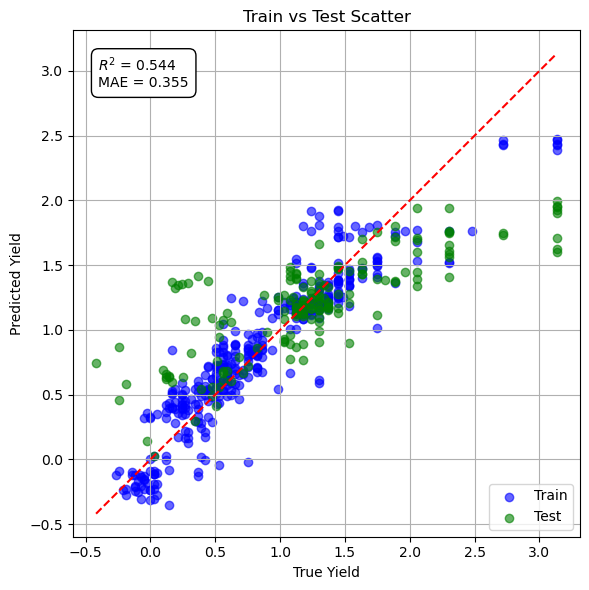

In [ ]:
classified_df = pd.read_csv('data/19_science/classified_idx.csv')
Train_idx = classified_df.index[classified_df['Subset'] == 'Train'].tolist()
Test_idx = classified_df.index[classified_df['Subset'] == 'Test_cat_sub'].tolist()  # 或 Test_sub/Test_cat_sub

print(len(Train_idx), len(Test_idx))

# 特征和标签
X = UniMol_19
y = classified_df['Output']

X_train = X.iloc[Train_idx]
y_train = y.iloc[Train_idx]
X_test = X.iloc[Test_idx]
y_test = y.iloc[Test_idx]

# -----------------------------
# Optuna 调参函数
# -----------------------------
def objective_lasso(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)    
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

def tune_model(name, objective, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    print(f"\nBest {name} params:", study.best_params)
    print(f"Best {name} MAE on test set: {study.best_value:.4f}")
    return study.best_params

# -----------------------------
# 调参 + 重新训练
# -----------------------------
lasso_best = tune_model("Lasso", objective_lasso, n_trials=200)

# 使用最优参数重新训练模型
model = Lasso(alpha=lasso_best['alpha'], max_iter=10000)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# 合并数据
all_true = np.concatenate([y_train, y_test])
all_preds = np.concatenate([train_preds, test_preds])

# 评估指标
r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

# -----------------------------
# 绘图
# -----------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_train, train_preds, color='blue', label='Train', alpha=0.6)
plt.scatter(y_test, test_preds, color='green', label='Test', alpha=0.6)
plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--')
plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Train vs Test Scatter')
plt.legend()
plt.grid(True)

# 添加评估指标（带边框）
plt.text(0.05, 0.95,
         f'$R^2$ = {r2:.3f}\nMAE = {mae:.3f}',
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.savefig(f'results/19_outsample/LASSO-SUB-CAT-train_test-scatter.png')
plt.show()